In [ ]:
#1.notebook should be run on kaggle
#2.before running code uncomment below two commands and run ,it will show error but ignore it.

# !pip install pyarrow==8.0.0
# !pip install transformers sentencepiece datasets rouge -qq

# ***Required Dependencies***

In [5]:
from transformers import AutoModel, AutoTokenizer  # Import specific modules or classes from the transformers library
import sentencepiece
from rouge import Rouge

In [6]:
import torch
import pandas as pd
from rouge import Rouge
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import plotly.express as px
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
!wget https://raw.githubusercontent.com/d0r1h/SAR/main/dataset/SARsample.csv -q
# reformated form here https://huggingface.co/datasets/ganeshjcs/hindi-article-summarization?row=2

In [8]:
data = pd.read_csv("./SARsample.csv")

In [9]:
text = data['text']
goldsummary = data['summary']

### **Model1 : BART**

BART, Bidirectional and Auto-Regressive Transformers, is a sequence-to-sequence model introduced by Facebook AI. It excels in various natural language processing tasks by utilizing a denoising autoencoder architecture, which incorporates bidirectional processing for contextual understanding and autoregressive generation for sequence generation.

In [10]:
bart_checkpoint = "ai4bharat/IndicBART"

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

***Configured BART tokenizer without lowercasing, using slower mode, preserving accents. Loaded BART model for sequence-to-sequence tasks on specified device***

In [12]:
tokenizer_bart = AutoTokenizer.from_pretrained(bart_checkpoint, 
                                               do_lower_case=False, 
                                               use_fast=False, 
                                               keep_accents=True)

model_bart = AutoModelForSeq2SeqLM.from_pretrained(bart_checkpoint).to(device)

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/832 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/398 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/931M [00:00<?, ?B/s]

***Identified BART token IDs: <s> (bos_id), </s> (eos_id), <pad> (pad_id). Essential for sequence generation and padding in BART-based models.***

In [13]:
bos_id = tokenizer_bart._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer_bart._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer_bart._convert_token_to_id_with_added_voc("<pad>")

***The code snippet uses the BART model and a tokenizer to generate summaries for a list of input texts. It iterates through the input, processes them, and stores the generated summaries in the 'SystemSummary' list using beam search and specified constraints on length.***

In [14]:
%%time

SystemSummary = []

for i, input_text in enumerate(text):
    
    inp = tokenizer_bart(input_text, add_special_tokens=False, 
                         truncation=True, return_tensors="pt", 
                         padding='max_length', max_length=1024)['input_ids'].to(device)  
    
    model_output = model_bart.generate(inp, use_cache=True, 
                                        num_beams=4, 
                                        max_length=70, 
                                        min_length=30, 
                                        early_stopping=True, 
                                        pad_token_id=pad_id,
                                        bos_token_id=bos_id, 
                                        eos_token_id=eos_id, 
                                        decoder_start_token_id=tokenizer_bart._convert_token_to_id_with_added_voc("<2en>"))
    
    decoded_output = tokenizer_bart.decode(model_output[0], 
                                    skip_special_tokens=True, 
                                    clean_up_tokenization_spaces=False)
    
    SystemSummary.append(decoded_output)

CPU times: user 20min 20s, sys: 3.3 s, total: 20min 24s
Wall time: 20min 27s


***The code generates summaries using BART model for provided text inputs, stores these in a DataFrame, 'Summaries', containing gold and BART-generated summaries, then displays the initial rows of the DataFrame.***

In [15]:
Summaries = pd.DataFrame(list(zip(goldsummary, SystemSummary)), columns =['GoldSummary', 'BartSummary'])
Summaries.head()

,GoldSummary,BartSummary
0,बिहार में भारतीय जनता पार्टी (बीजेपी) अपने सहय...,आगामी लोकसभा चुनाव में राज्य की कुल 40 सीटों म...
1,क्रिस गेल ने कहा चैंपियंस ट्रॉफी में पाकिस्तान...,वेस्टइंडीज के आक्रामक बल्लेबाज क्रिस गेल ने कह...
2,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...
3,ट्विंकल खन्ना ने वजाइना से जुड़े कई सवालों के ...,अकसर अपने ट्वीट्स को लेकर चर्चा में रहने वाली ...
4,दुनिया भर में ग़लत तरीके से सड़क पार करने पर ज...,कहा जाता है कि अमरीका में 1920 के दशक में मोटर...


**ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is used in natural language processing to assess the quality of generated text against reference (gold) summaries. It measures the similarity between the model-generated summaries and human-written references, providing a standardized way to evaluate the effectiveness and accuracy of text summarization models.**

***The code uses Rouge to evaluate BART model-generated summaries against gold standards, computing recall, precision, and f-measure. Results are stored in a DataFrame, 'BartRouge,' summarizing evaluation metrics for the model's performance compared to the reference summaries.***

In [16]:
rouge = Rouge()
score = rouge.get_scores(Summaries['BartSummary'], Summaries['GoldSummary'], avg=True)
BartRouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
BartRouge

,rouge-1,rouge-2,rouge-l
recall,0.524375,0.305393,0.470940
precision,0.318803,0.168727,0.286694
f-measure,0.392498,0.214855,0.352787


### **Model2 : T5**

T5, Text-to-Text Transfer Transformer, is a versatile transformer-based model by Google Research. It's designed to process various natural language tasks by converting them into a unified text-to-text format, enabling the model to handle a wide range of tasks with consistent input-output structures.

***The code initializes a T5 model and tokenizer from a specified checkpoint, enabling sequence-to-sequence tasks. The tokenizer processes text data, while the model is loaded onto the device for computation.***

In [17]:
t5_checkpoint = "csebuetnlp/mT5_multilingual_XLSum"

tokenizer_t5 = AutoTokenizer.from_pretrained(t5_checkpoint)
model_t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_checkpoint).to(device)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/730 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

***The code utilizes a pre-trained T5 model to generate summaries for a list of input texts, with a focus on controlling summary length and avoiding repetition, recording the results in 'SystemSummary1'.***

In [18]:
%%time

SystemSummary1 = []

for i, input_text in enumerate(text):    
    
    input_ids = tokenizer_t5(input_text,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=768)["input_ids"].to(device) 

    model_output = model_t5.generate(input_ids=input_ids,
                                     num_beams=4,
                                     max_length=70,
                                     min_length=30,
                                     no_repeat_ngram_size=2,
                                     early_stopping=True)

    decoded_output = tokenizer_t5.decode(model_output[0],
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=False)
    
    SystemSummary1.append(decoded_output)

CPU times: user 45min 22s, sys: 1.07 s, total: 45min 23s
Wall time: 45min 22s


In [19]:
Summaries['T5Summary'] = SystemSummary1

***The code processes T5 model outputs and gold summaries, creating a DataFrame. It uses ROUGE to compute recall, precision, and F-measure scores for T5 model summaries against gold references, presented in a DataFrame for evaluation.***

In [21]:
rouge = Rouge()
score = rouge.get_scores(Summaries['T5Summary'], Summaries['GoldSummary'], avg=True)
T5Rouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
T5Rouge

,rouge-1,rouge-2,rouge-l
recall,0.358953,0.177884,0.310272
precision,0.478681,0.246412,0.412407
f-measure,0.402849,0.202179,0.347753


### **Model3 : prophetnet**

ProphetNet, from Microsoft Research, is a self-supervised transformer model designed for sequence-to-sequence learning tasks. It introduces n-gram masking to improve the learning process, enhancing the model's ability to generate coherent and contextually relevant text across various language generation tasks.

***The code initializes ProphetNet, a large uncased transformer model by Microsoft, for sequence-to-sequence tasks. It sets up the ProphetNet tokenizer and model to be used for conditional generation, enabling text generation and comprehension tasks in a lower-cased context.***

In [25]:
from transformers import ProphetNetForConditionalGeneration, ProphetNetTokenizer
prophetnet_checkpoint = "microsoft/prophetnet-large-uncased"

tokenizer_prophetnet = ProphetNetTokenizer.from_pretrained(prophetnet_checkpoint, do_lower_case=True)

model_prophetnet = ProphetNetForConditionalGeneration.from_pretrained(prophetnet_checkpoint).to(device)

***This code segment uses ProphetNet, a transformer-based model, to generate text summaries. It processes input text, utilizes a pre-trained ProphetNet model, and generates concise summaries, facilitating efficient text summarization tasks across varied inputs.***

In [28]:
%%time

SystemSummary2 = []


for i, input_text in enumerate(text):
    
    inp = tokenizer_prophetnet(input_text, return_tensors="pt", max_length=1024, truncation=True)['input_ids'].to(device)  
    
    model_output = model_prophetnet.generate(inp, use_cache=True, 
                                             num_beams=4, 
                                             max_length=70, 
                                             min_length=30, 
                                             early_stopping=True)
    
    decoded_output = tokenizer_prophetnet.decode(model_output[0], 
                                                 skip_special_tokens=True, 
                                                 clean_up_tokenization_spaces=False)
    
    SystemSummary2.append(decoded_output)

CPU times: user 17min 51s, sys: 1.79 s, total: 17min 53s
Wall time: 17min 52s


In [31]:
Summaries['ProphetNETSummary'] = SystemSummary2

In [32]:
rouge = Rouge()
score = rouge.get_scores(Summaries['ProphetNETSummary'], Summaries['GoldSummary'], avg=True)
ProphetNETRouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
ProphetNETRouge

,rouge-1,rouge-2,rouge-l
recall,0.523433,0.304408,0.469922
precision,0.318942,0.168470,0.286732
f-measure,0.392046,0.214287,0.352250


### **Model4 : pegasus**

Pegasus, developed by Google Research, is a powerful sequence-to-sequence model specialized in abstractive text summarization. Using self-supervised pre-training, it achieves highly effective summarization by understanding and compactly representing input text to produce accurate, coherent, and condensed summaries.

***The code initializes the Pegasus model and tokenizer, "pegasus-large" variant, allowing generation of concise, accurate, and coherent text summaries. It's equipped for abstractive summarization tasks, extracting key information from input text efficiently.***

In [33]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
pegasus_checkpoint = "google/pegasus-large"
tokenizer_pegasus = PegasusTokenizer.from_pretrained(pegasus_checkpoint)
model_pegasus = PegasusForConditionalGeneration.from_pretrained(pegasus_checkpoint)

***This code employs Pegasus, a robust transformer model, to generate concise text summaries. It processes input text, utilizes Pegasus' pre-trained model, and produces accurate, abridged summaries via advanced sequence-to-sequence learning within minimal computational time.***

In [35]:
%%time

SystemSummary3 = []
for i, input_text in enumerate(text):  
    input_ids = tokenizer_pegasus.encode(input_text, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = model_pegasus.generate(input_ids, max_length=70, min_length=30, num_beams=4, early_stopping=True)
    decoded_output = tokenizer_pegasus.decode(summary_ids[0], skip_special_tokens=True)
    SystemSummary3.append(decoded_output)

CPU times: user 12min 51s, sys: 2.21 s, total: 12min 53s
Wall time: 12min 53s


In [36]:
Summaries['PegasusSummary'] = SystemSummary3

In [37]:
rouge = Rouge()
score = rouge.get_scores(Summaries['PegasusSummary'], Summaries['GoldSummary'], avg=True)
PegasusRouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
PegasusRouge

,rouge-1,rouge-2,rouge-l
recall,0.197775,0.012016,0.178221
precision,0.109898,0.005869,0.098602
f-measure,0.139841,0.007790,0.125659


### **Which model from the four is the most optimal?**


Looking at the scores:
- **Model 1**: Highest recall and f-measure for all metrics, indicating better overall performance.
- **Model 2**: High precision but relatively lower recall and f-measure.
- **Model 3**: Similar to Model 1 but slightly lower scores.
- **Model 4**: Significantly lower scores across all metrics.

The choice of the 'best' model depends on the task's priorities. Model 1 showcases the highest recall and f-measure, suggesting it retrieves more relevant information from the reference summaries. However, if precision is critical to avoid false positives, Model 2's high precision might be preferred.

In many scenarios, a balance between precision and recall is sought, favoring models with balanced F1 scores. Considering this, Model 1 stands out due to its higher overall F1 score.

***Therefore, Model 1 might be considered the best due to its balance between recall and precision, making it a suitable choice for generating comprehensive and accurate summaries.***

### **Plotting Rouge Score**

*****The code generates a grouped bar chart using Plotly, depicting Rouge scores for different algorithms. It visualizes the comparison of Rouge metrics, such as recall, precision, and F-measure, providing a clear, concise graphical representation for evaluating algorithm performance.*****

In [42]:
T5Rouge = T5Rouge[['rouge-1','rouge-l', 'rouge-2']]
BartRouge = BartRouge[['rouge-1','rouge-l', 'rouge-2']]
ProphetNETRouge = ProphetNETRouge[['rouge-1','rouge-l', 'rouge-2']]
PegasusRouge = PegasusRouge[['rouge-1','rouge-l', 'rouge-2']]

For Bart

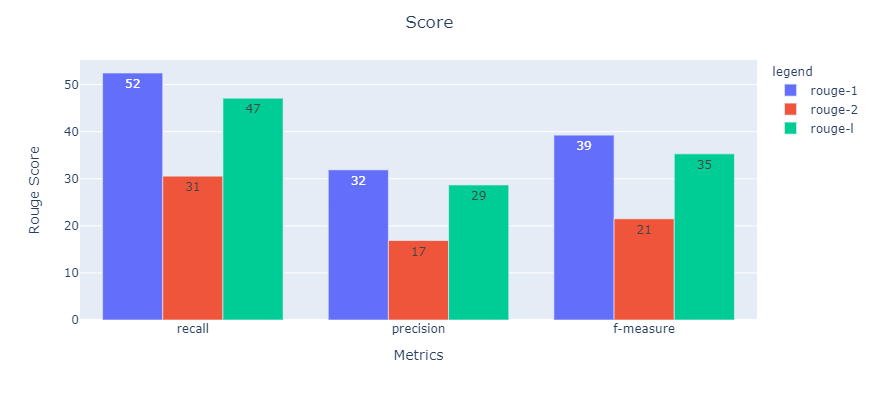

In [39]:
fig = px.bar(BartRouge*100, x=BartRouge.index, y=BartRouge.columns, 
             barmode='group', 
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })
fig.update_layout( width=650,
                  height=400,
                title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()

For T5

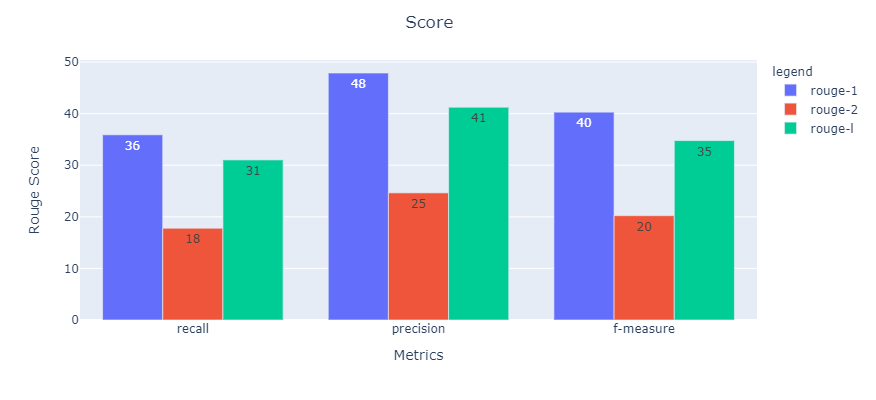

In [40]:
fig = px.bar(T5Rouge*100, x=T5Rouge.index, y=T5Rouge.columns, 
             barmode='group', 
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })

fig.update_layout(width=650,
                  height=400,
                  title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()

For Pegasus

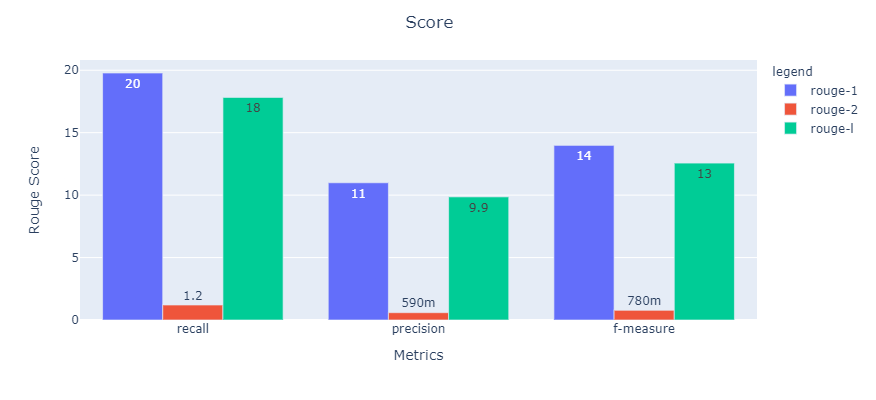

In [42]:
fig = px.bar(PegasusRouge*100, x=PegasusRouge.index, y=PegasusRouge.columns, 
             barmode='group', 
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })

fig.update_layout(width=650,
                  height=400,
                  title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()

For ProphetNET

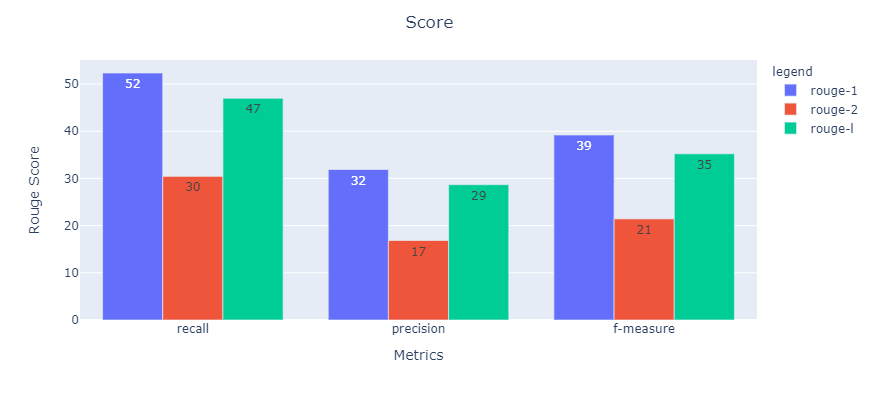

In [41]:
fig = px.bar(ProphetNETRouge*100, x=ProphetNETRouge.index, y=ProphetNETRouge.columns, 
             barmode='group', 
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })

fig.update_layout(width=650,
                  height=400,
                  title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()

### **Sample Summaries**

In [43]:
[i for i in Summaries['GoldSummary'][:5]]

['बिहार में भारतीय जनता पार्टी (बीजेपी) अपने सहयोगी जनता दल यूनाइटेड (जेडीयू) और लोक जनशक्ति पार्टी (एलजेपी) से क़दम-क़दम पर समझौता करने को विवश दिख रही है.',
 'क्रिस गेल ने कहा चैंपियंस ट्रॉफी में पाकिस्तानी पर भारी पड़ेगा भारत क्रिस गेल ने पाकिस्तान को पंसदीदा टीम बताया 18 जून से इंग्लैंड और वेल्स में शुरू होगा चैम्पियंस ट्रॉफी टूर्नामेंट',
 'म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान ने कहा कि वह तब तक बातचीत नहीं करेंगे जब तक लोग प्रदर्शन बंद कर अपने घरों को नहीं लौटेंगे।',
 'ट्विंकल खन्ना ने वजाइना से जुड़े कई सवालों के दिए जवाब. ट्विंकल खन्ना ने सोशल मीडिया पर शेयर की पोस्ट. ट्विंकल खन्ना ने अपने ब्लॉक में दिए 11 सवालों के जवाब.',
 'दुनिया भर में ग़लत तरीके से सड़क पार करने पर जुर्माना लगाए जाने का प्रावधान है लेकिन अमरीका में ऐसी ग़लती करने पर जिस तरह के क़ायदे कानून हैं, वह किसी भी विदेशी आगंतुक को चौंका सकता है.']

In [44]:
[i for i in Summaries['T5Summary'][:5]]

['बिहार में विधानसभा चुनावों के लिए बीजेपी और जनता दल यूनाइटेड (जेडीयू) जैसे तीनों घटक राजनीतिक दलों की उम्मीदवारी लड़ने की तैयारी कर रहे हैं.',
 'आईसीसी चैम्पियंस ट्रॉफी में अगले महीने भारत और पाकिस्तान के बीच होने वाले मुकाबले में भारत का पलड़ा भारी रहेगा.',
 'मिस्र के राष्ट्रपति हुस्नी मुबारक ने सरकार विरोधी प्रदर्शनकारियों के साथ बातचीत शुरू करने का आग्रह किया है.',
 'बॉलीवुड की एक्ट्रेस ट्विंकल खन्ना ने एक और ब्लॉग लिखते हुए 11 सवालों के जवाब दिए हैं.',
 'अमरीका में लाल बत्ती पर सड़क पार करने पर रोक लगा दी गई है और इसके लिए कई लोगों को जुर्माना लगाया गया है.']

In [45]:
[i for i in Summaries['BartSummary'][:5]]

['आगामी लोकसभा चुनाव में राज्य की कुल 40 सीटों में से जिन सीटों पर राष्ट्रीय जनतांत्रिक गठबंधन (एनडीए) के ये तीनों घटक चुनाव लड़ेंगे, उनकी सूची से भी बीजेपी की मजबूरी झलक उठती है. यानी राज्य के मुख्यमंत्री और जेडीयू के अध्यक्ष नीतीश कुमार ने सीटों के चयन में अपने दलीय हित के अनुकूल बीजेपी नेतृत्व को जैसे',
 'वेस्टइंडीज के आक्रामक बल्लेबाज क्रिस गेल ने कहा है कि अगले महीने शुरू होने वाली आईसीसी चैम्पियंस ट्रॉफी में भारत और पाकिस्तान के बीच होने वाले मुकाबले में भारत का पलड़ा भारी रहेगा. भारत और पाकिस्तान चार जून को चैम्पियंस ट्रॉफी में आमने सामने होंगे. गेल ने हालांकि भारत और पाकिस्तान को अपनी पसंदीदा टीमें भी बताया.एक कार्यक्रम',
 'म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान ने बुधवार को कहा कि वह विपक्ष के साथ तब तक बातचीत नहीं करेंगे जब तक लोग प्रदर्शन बंद कर अपने घरों को नहीं लौटेंगे। समाचार एजेंसी डीपीए के मुताबिक सुलेमान ने कहा "राष्ट्रपति हुस्नी मुबारक ने विपक्ष के साथ बातचीत शुरू करने का आग्रह किया है लेकिन यह तब तक',
 'अकसर अपने ट्वीट्स को लेकर चर्चा में रहने वाली बॉलीवुड के